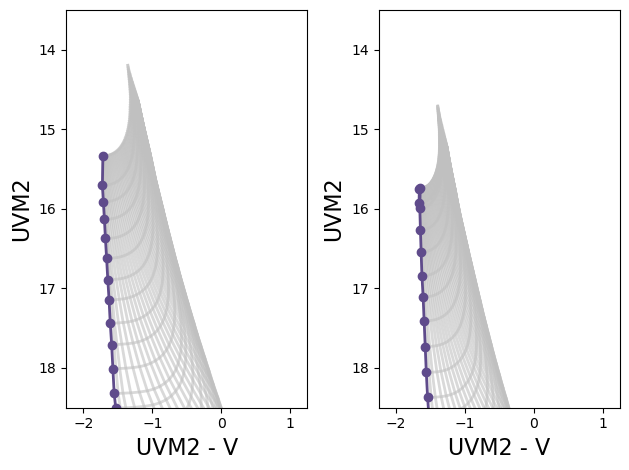

In [ ]:
# The generate_composite_grid file creates a composite grid of MIST isochrones with Ylva's stripped star models
# Author: Bethany Ludwig 
# Date: 2024-05-01
# Models Accessed with: https://waps.cfa.harvard.edu/MIST/interp_tracks.html
# For metallicities: 
# LMC-like: log10(0.006/0.0142) = -0.37
# SMC-like: log10(0.002/0.0142) = -0.85
# Masses: 
# [1, 12.4, steps=0.2]
# For stripped star models I'll use photometry_CMFGEN_composites for the lmc 
# This wasn't run for the smc so I'll use Gotberg 2018 model for that
# This notebook applies a range of extinctions to the grid and saves the results to a csv file

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from generate_composite_grid import *

# Data Directory
import os
data_dir = os.getenv("DATADIR")

# Generate the composite grid 
lmc = CompositePhotometry('lmc', data_dir, data_dir+'0_SUMS_Catalogs/CompositeGrid/lmc_composite_photometry.csv')
smc = CompositePhotometry('smc', data_dir, data_dir+'0_SUMS_Catalogs/CompositeGrid/smc_composite_photometry.csv')

# Take a look at the grid 
f, axes = plt.subplots(1,2)
for ax, composite_df in zip(axes, [lmc.composite_df, smc.composite_df]):

    for M in composite_df.M_MS.unique():
        comp_row = composite_df[(composite_df.M_MS == M) & (composite_df.frac_MS == 0.2)]
        ax.plot(comp_row.UVM2 - comp_row.V,comp_row.UVM2,color='silver',linewidth=2,alpha=0.6)

    for M in composite_df.Minit_strip.unique():
        comp_row = composite_df[(composite_df.Minit_strip == M) ] 
        ax.plot(comp_row.UVM2 - comp_row.V,comp_row.UVM2,color='silver',linewidth=2,alpha=0.6)
        
    evol = composite_df[composite_df.frac_MS == 0]
    ax.plot(evol.UVM2 - evol.V,evol.UVM2,color='#5F4B8B',linewidth=2,alpha=1,marker='o')
    ax.set_xlim(-2.25,1.25)
    ax.set_ylim(18.5,13.5)
    fs = 16
    ax.set_xlabel('UVM2 - V',fontsize=fs)
    ax.set_ylabel('UVM2',fontsize=fs)
plt.tight_layout()

In [2]:
# Our fiducial extinction coefficients
smc_extinction_coeff = {
		'UVW2' : 3.522767303652845,
		'UVM2' : 3.062652780996107,
		'UVW1' : 2.7436011426496876,
		'U'  : 1.746851127566682,
		'B'  : 1.4073996800012445,
		'V'  : 1.0353852912271932,
		'I'  : 0.5911705440475679,
	}
lmc_extinction_coeff = {
    'UVW2' : 2.644541680555541,
    'UVM2' : 2.7233599880955124,
    'UVW1'  : 2.3536449902431045,
    'U'  : 1.5634790597438197,
    'B'  : 1.3170082045312625,
    'V'  : 1.0333402844940784,
    'I'  : 0.7366865234305091,
}
# Our fiducial Av 
smc_av = 0.22
lmc_av = 0.38 

# Av Ranges:
# https://ui.adsabs.harvard.edu/abs/2002AJ....123..855Z # SMC, Fig 19
# https://ui.adsabs.harvard.edu/abs/2004AJ....128.1606Z # LMC, Fig 9
av_range = np.arange(0.01,1.,0.02) # Increasing the resolution will obviously slow down the fitting process quite a bit.


# Apply some level of extinction and then make one big grid 
def apply_extinction(df, extinction_coeff, av):
    # Copy the dataframe
    df_extincted = df.copy()
    # Apply the extinction
    for band in extinction_coeff.keys():
        df_extincted[band] = df[band] + extinction_coeff[band] * av
    # Add the Av column
    df_extincted['Av'] = av
    return df_extincted

smc_dfs = []
lmc_dfs = []
for av in av_range:
    smc_dfs.append(apply_extinction(smc.composite_df, smc_extinction_coeff, av))
    lmc_dfs.append(apply_extinction(lmc.composite_df, lmc_extinction_coeff, av))

# Concatenate the dataframes
smc_extincted = pd.concat(smc_dfs)
lmc_extincted = pd.concat(lmc_dfs)

# Save the dataframes
smc_extincted.to_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/smc_composite_photometry_extincted.csv', index=False)
lmc_extincted.to_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/lmc_composite_photometry_extincted.csv', index=False)

# How big are these
print('Save Complete')
print('SMC Size: ',smc_extincted.shape[0])
print('LMC Size: ',lmc_extincted.shape[0])


Save Complete
SMC Size:  68350
LMC Size:  70750


[(-2.5, 1.0), (-2.5, 1.0)]

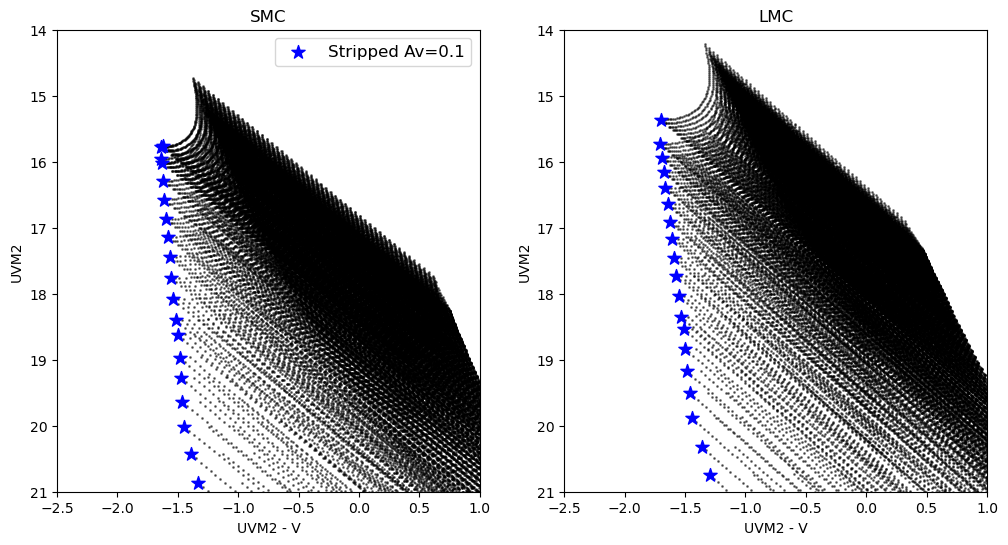

In [3]:
# Take another look at the grid 
# Stripped star models have 0 extinction and are best case scenario so applying extinction moves them to the right
# The maximum mass of the models is around 7 Msun so we won't be able to fit more massive stripped stars like A18 very well with this 
s_ss = smc_extincted[(smc_extincted.Av == 0.01) & (smc_extincted.M_MS == 0.0)]
l_ss = lmc_extincted[(lmc_extincted.Av == 0.01) & (lmc_extincted.M_MS == 0.0)]

f, axes = plt.subplots(1,2, figsize=(12,6))
alpha = 0.4
axes[0].scatter(smc_extincted.UVM2 - smc_extincted.V, smc_extincted.UVM2, s=1, c='k', alpha=0.5)
axes[0].scatter(s_ss.UVM2 - s_ss.V, s_ss.UVM2, s=100, c='b',label='Stripped Av=0.1',alpha=1,marker='*')
axes[0].set_xlabel('UVM2 - V')
axes[0].set_ylabel('UVM2')
axes[0].set_title('SMC')
axes[0].invert_yaxis()
axes[1].scatter(lmc_extincted.UVM2 - lmc_extincted.V, lmc_extincted.UVM2, s=1, c='k', alpha=0.5)
axes[1].scatter(l_ss.UVM2 - l_ss.V, l_ss.UVM2, s=100, c='b',label='Stripped Only Av=0.1',alpha=1,marker='*')
axes[1].set_xlabel('UVM2 - V')
axes[1].set_ylabel('UVM2')
axes[1].set_title('LMC')
axes[1].invert_yaxis()
axes[0].legend(loc='upper right',fontsize=12)

[ax.set_ylim(21,14) for ax in axes]
[ax.set_xlim(-2.5,1) for ax in axes]